In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import scanpy as sc
from anndata import read_h5ad

import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import early_stopping

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [2]:
import gc

# Delete possibly lingering objects from last run
for var in ['gbm', 'lgb_train', 'lgb_eval', 'X_train', 'x_test', 'Y_train', 'y_test']:
    if var in globals():
        del globals()[var]

gc.collect()
print("Memory cleared.")

Memory cleared.


## Step 1: Only use normal and type 2 data

In [3]:
# Filter for 'normal' and 'type 2 diabetes mellitus' only
#adata_filtered = adata[adata.obs['disease'].isin(['normal', 'type 2 diabetes mellitus'])].copy()
#adata_filtered.write('filtered_normal_vs_type2.h5ad')
#adatafilt = sc.read_h5ad("filtered_normal_vs_type2.h5ad")
adatafilt = sc.read_h5ad("filtered_normal_vs_type2_10percent.h5ad")
#adatafilt = sc.read_h5ad("filtered_normal_vs_type2_5percent.h5ad")

In [4]:
## Get features and labels
#y = adatafilt.obs['disease']
#
## Use train_test_split to keep xx% with same distribution
#_, idx_keep = train_test_split(
#    adatafilt.obs.index,  # Cell IDs (index)
#    test_size=0.25,       # Keep xx%
#    stratify=y,           # Preserve class balance
#    random_state=42
#)
#
## Subset AnnData to those cells
#adata_small = adatafilt[idx_keep].copy()
#adata_small.write("filtered_normal_vs_type2_25percent.h5ad")

## Step 2: How is the data structured?


In [5]:
#print("Original data:")
#print("Number of cells:", adata.n_obs)
#print("Number of genes:", adata.n_vars)
print("Filtered data:")
print("Number of cells:", adatafilt.n_obs)
print("Number of genes:", adatafilt.n_vars)

print(adatafilt.obs['disease'].value_counts())

Filtered data:
Number of cells: 23434
Number of genes: 31202
normal                      13459
type 2 diabetes mellitus     9975
Name: disease, dtype: int64


If a gene is always expressed at the same level in all cells → variance is 0

If a gene is expressed in some cells but not others, or at very different levels → variance is high

So genes with largest variance must be the most important ones.

In [6]:
#sc.pp.highly_variable_genes(adatafilt, n_top_genes=100, flavor='cell_ranger')
#adatafilt = adatafilt[:, adatafilt.var['highly_variable']].copy()

# Convert sparse matrix to dense temporarily (can also do in batches for big data)
X_dense = adatafilt.X.toarray()

# Calculate variance across cells for each gene (axis=0)
gene_variances = np.var(X_dense, axis=0)

# Get indices of top N variable genes (e.g. 100)
top_gene_indices = np.argsort(gene_variances)[-100:]

# Subset AnnData object to just those genes
adatafilt = adatafilt[:, top_gene_indices].copy()

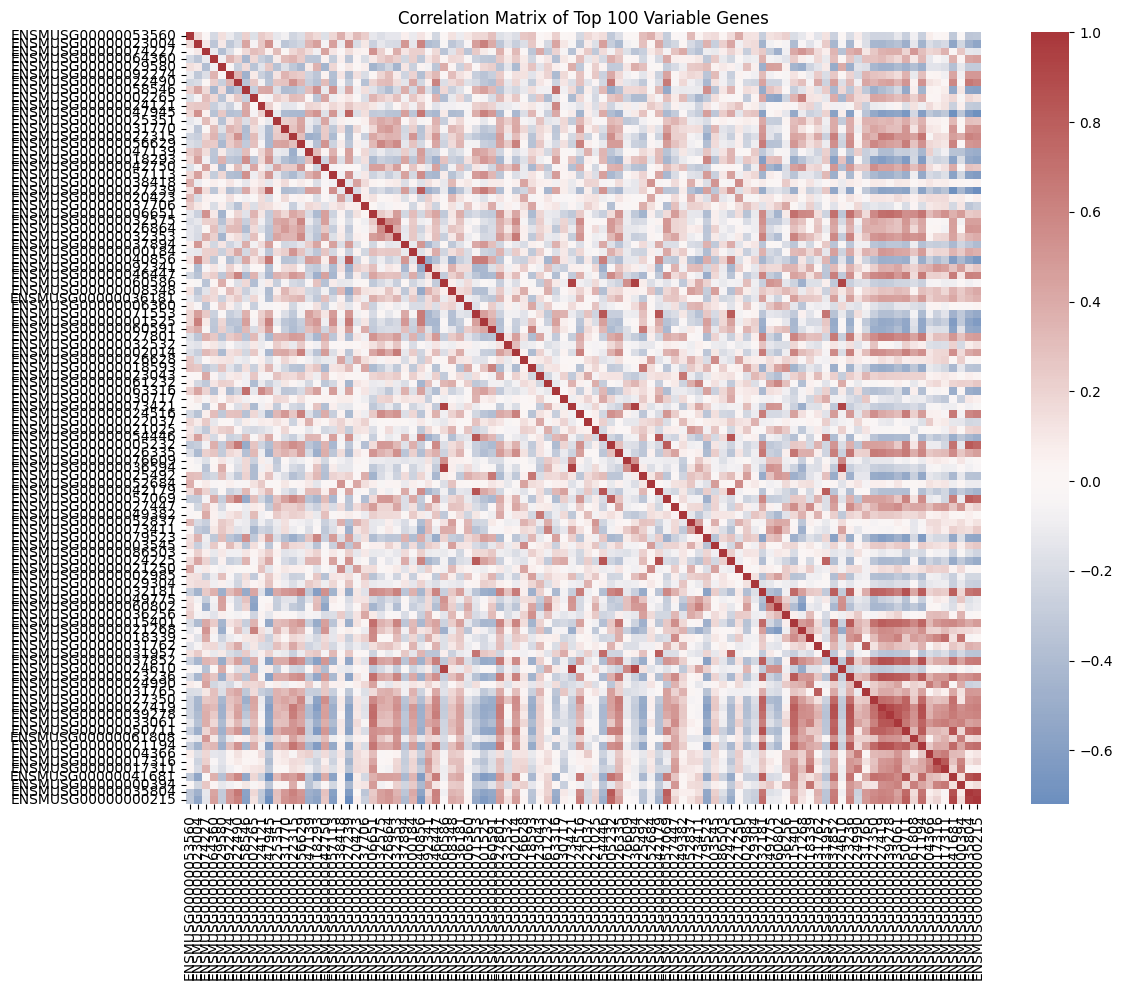

In [7]:
X_dense_top = adatafilt.X.toarray()
gene_names = adatafilt.var_names
df = pd.DataFrame(X_dense_top, columns=gene_names)

corr_matrix = df.corr(method='pearson')  # You can also try 'spearman'

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='vlag', center=0, xticklabels=True, yticklabels=True)
plt.title("Correlation Matrix of Top 100 Variable Genes")
plt.tight_layout()
plt.show()

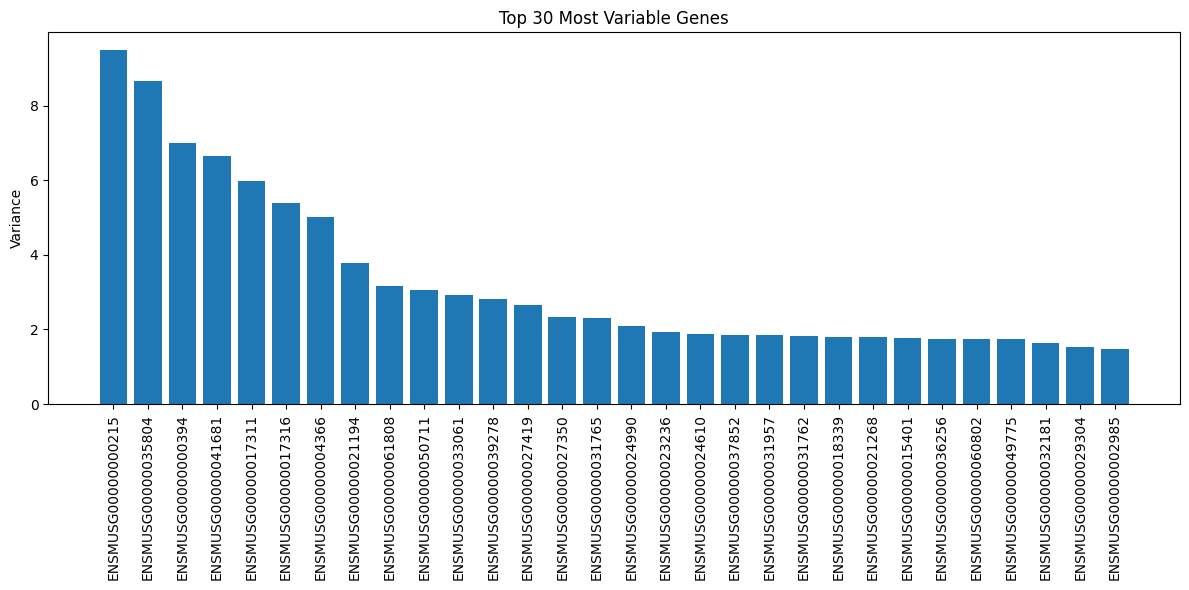

In [8]:
X = adatafilt.X.toarray() if not isinstance(adatafilt.X, np.ndarray) else adatafilt.X
gene_variances = np.var(X, axis=0)


# Create a DataFrame with gene names and their variances
var_df = pd.DataFrame({
    'gene': adatafilt.var_names,
    'variance': gene_variances
})

# Sort and take top 30
top_var_df = var_df.sort_values('variance', ascending=False).head(30)

feature_names = list(adatafilt.var_names)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(top_var_df['gene'], top_var_df['variance'])
plt.xticks(rotation=90)
plt.ylabel('Variance')
plt.title('Top 30 Most Variable Genes')
plt.tight_layout()
plt.show()

## try training LightGBM

In [9]:

# Get features and labels
X = adatafilt.X.toarray().astype(np.float32)
y = adatafilt.obs['disease']

print("X shape:", X.shape)

# Encode labels - turn disease labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(le.classes_)

# Train/test split
X_train, x_test, Y_train, y_test = train_test_split(X, y_encoded, test_size=0.9, random_state=42)

print("So far so good")


X shape: (23434, 100)
['normal' 'type 2 diabetes mellitus']
So far so good


In [10]:
print("Training session:")

# Feed the datasets to LightGBM:
lgb_train = lgb.Dataset(X_train, Y_train, feature_name=feature_names)
lgb_eval  = lgb.Dataset(x_test,  y_test, reference=lgb_train, feature_name=feature_names)

# Set parameters for LightGBM (known more generally as "hyper parameters"):
params = {
    'boosting_type': 'gbdt', # Traditional Gradient Boosting tree, we are combining many 'weak' learners here!
    'objective': 'binary',   # The outcome is binary, b-quark or not
    'num_leaves': 6,         # Set a maximum tree leaves to avoid overfitting
    'verbose': 1,            # Level of output. Can be set to -1 to suppress the output
    'num_threads': 1 
}

# Train the model:
gbm = lgb.train(params,                             # General settings (defined above)
                lgb_train,                          # Data to use for training
                num_boost_round=1000,                 # How many rounds for training
                valid_sets=lgb_eval,                # Data to use for validation
                callbacks=[early_stopping(30)]     # Stops if no improvement is seen in N=20 rounds.   
                )                  
# Make predictions.
# NOTE the difference between 'score' (continuous in ]0,1[) and 'predictions' (integer: 0 or 1):
# Also NOTE that you can choose where to set the threshold (here set to 0.1)
print("Best iteration:", gbm.best_iteration)
y_score = gbm.predict(x_test, num_iteration=gbm.best_iteration)  # Scores are floats in the range ]0,1[.
y_pred  = [1 if pred > 0.1 else 0 for pred in y_score]               
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr) 

gbm.save_model("model.txt")

Training session:
[LightGBM] [Info] Number of positive: 957, number of negative: 1386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23978
[LightGBM] [Info] Number of data points in the train set: 2343, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408451 -> initscore=-0.370374
[LightGBM] [Info] Start training from score -0.370374
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.0783487
Best iteration: 282


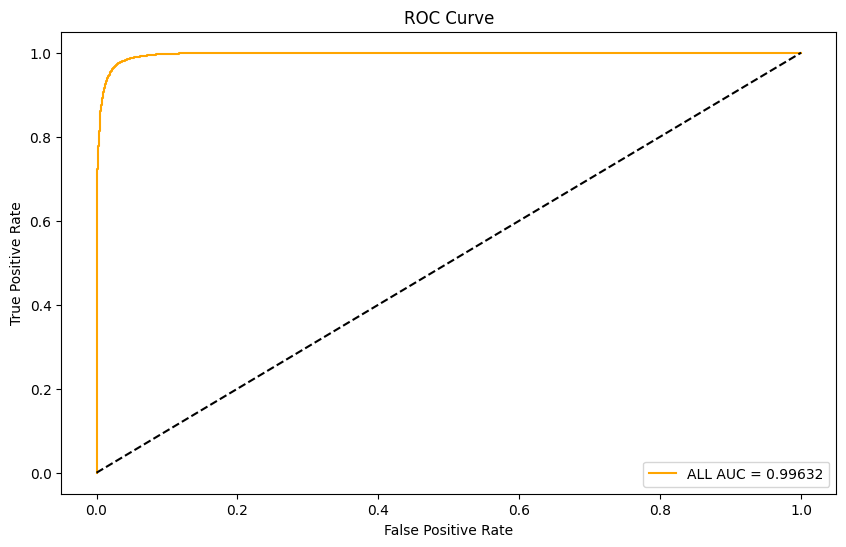

In [11]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', label='ALL AUC = %0.5f' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

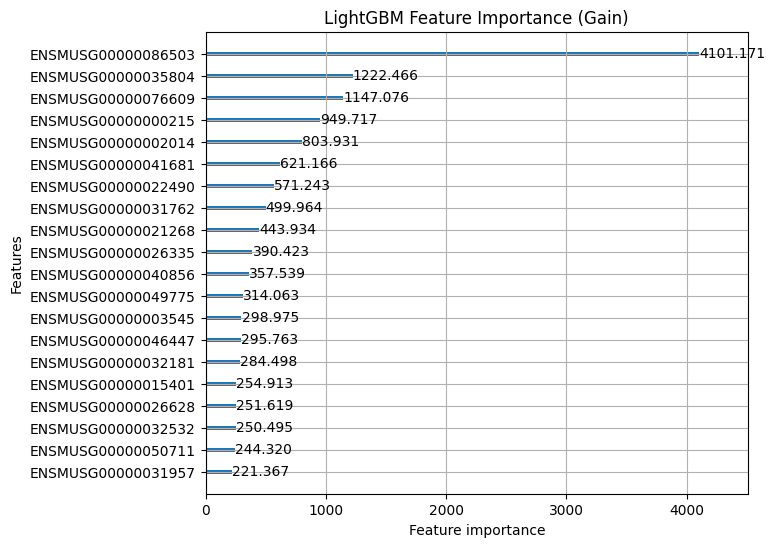

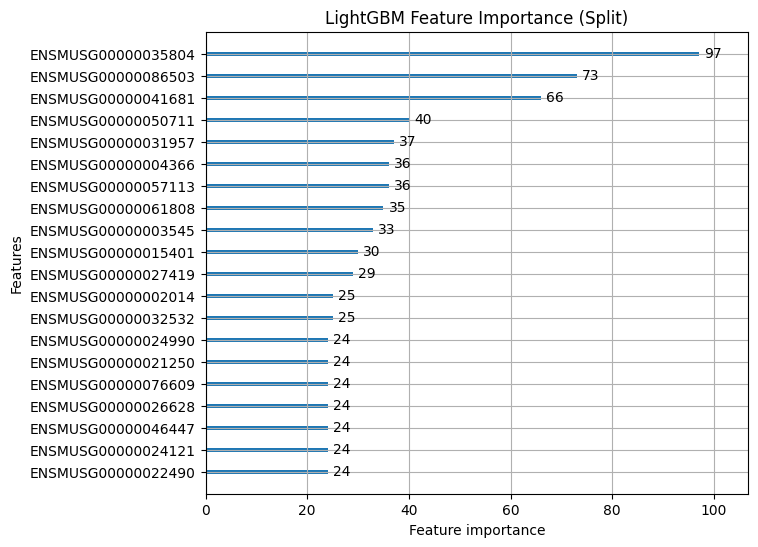

In [12]:
#gbm_save = lgb.Booster(model_file="model.txt")

# GAIN
# Plot feature importance using Gain
lgb.plot_importance(gbm, importance_type="gain", max_num_features=20, figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

# Get feature importances (gain) and names
importances_gain = gbm.feature_importance(importance_type='gain')
feature_names_gain = gbm.feature_name()
feature_importance_gain = list(zip(feature_names_gain, importances_gain))
sorted_features_gain = sorted(feature_importance_gain, key=lambda x: x[1], reverse=True)
top_25_gain = [name for name, _ in sorted_features_gain[:20]]

lgb.plot_importance(gbm, importance_type="split", max_num_features=20, figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

# Get feature importances (gain) and names
importances_split = gbm.feature_importance(importance_type='split')
feature_names_split = gbm.feature_name()
feature_importance_split = list(zip(feature_names_split, importances_split))
sorted_features_split = sorted(feature_importance_split, key=lambda x: x[1], reverse=True)
top_25_split = [name for name, _ in sorted_features_split[:20]]

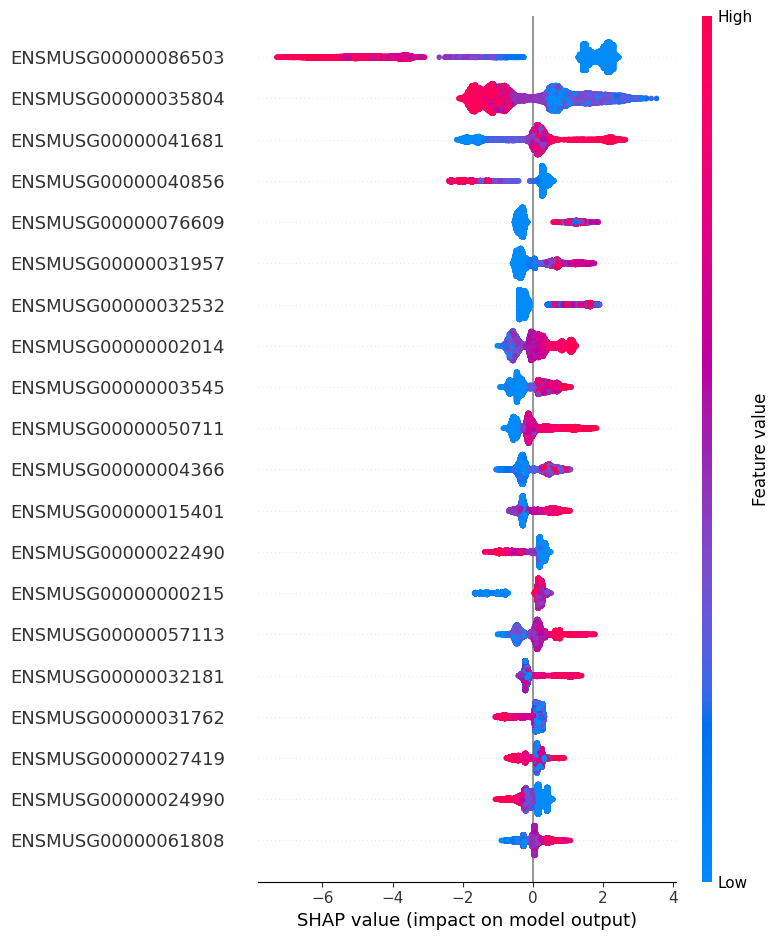

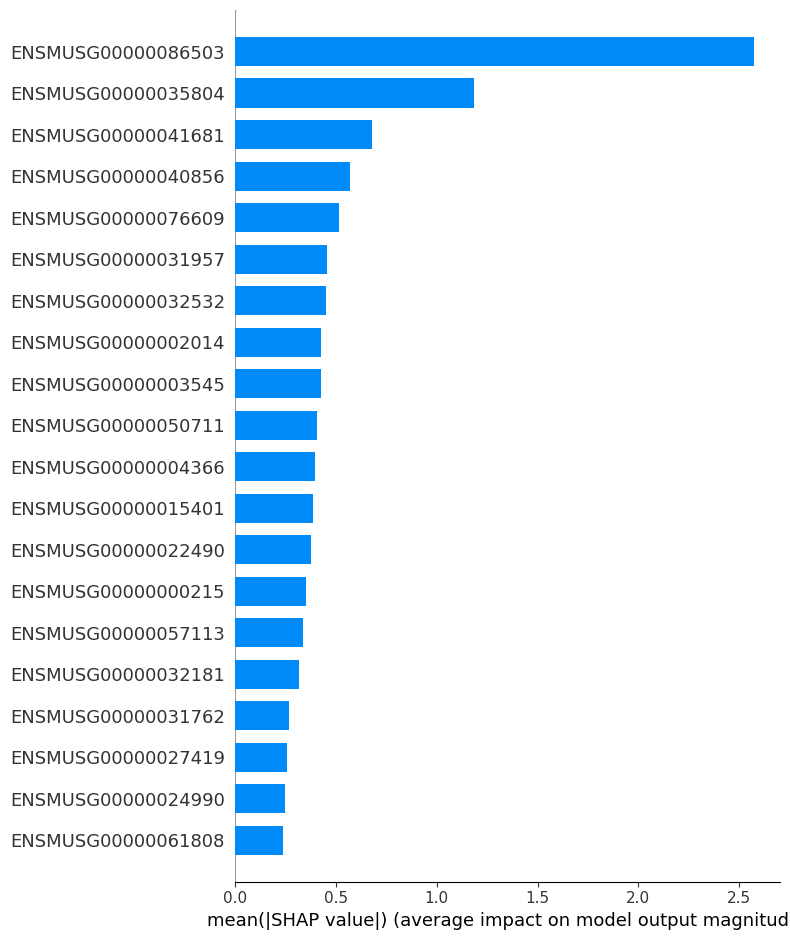

In [ ]:
import shap
import pandas as pd

# Use correct feature names
feature_names = list(adatafilt.var_names)
X_df = pd.DataFrame(X, columns=feature_names)


explainer = shap.TreeExplainer(gbm)
shap_values = explainer(X_df)

#shap.summary_plot(shap_values, input_data)
shap.summary_plot(shap_values, X_df)
shap.summary_plot(shap_values, X_df, plot_type="bar")

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=adatafilt.var_names)


In [14]:
from mygene import MyGeneInfo
mg = MyGeneInfo()

info = mg.getgene("ENSMUSG00000035804", species='mouse', fields="symbol,name,summary")

import pprint
pprint.pprint(info)

Input sequence provided is already in string format. No operation performed


{'_id': '16333',
 '_version': 1,
 'name': 'insulin I',
 'summary': 'This gene encodes insulin, a peptide hormone that plays a vital '
            'role in the regulation of carbohydrate and lipid metabolism. The '
            'encoded precursor protein undergoes proteolytic cleavage to '
            'produce a disulfide-linked heterodimeric functional protein that '
            'is stored in secretory granules. An increase in blood glucose '
            'levels, among others, induces the release of insulin from the '
            'secretory granules. Mice deficient in the functional hormone '
            'encoded by this gene develop diabetes mellitus. [provided by '
            'RefSeq, Aug 2015].',
 'symbol': 'Ins1'}
